In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.diverging import PuOr_7
from palettable.cartocolors.sequential import PurpOr_6

from ideotype.data_process import (read_data,
                                   fetch_norm_mean_disp,
                                   fetch_mean_disp_diff,
                                   agg_sims)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               phenostage_climate)
from ideotype.figures import (plot_rankchange,
                              plot_params_heatmap,
                              plot_cspace_rank,
                              plot_cspace_yield,
                              plot_mean_disp_change)
from ideotype.init_params import params_sample
from ideotype.utils import fold
from ideotype.data_process import parse_mature
from ideotype import DATA_PATH

In [2]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

## Visualize change in phenotype ranking 

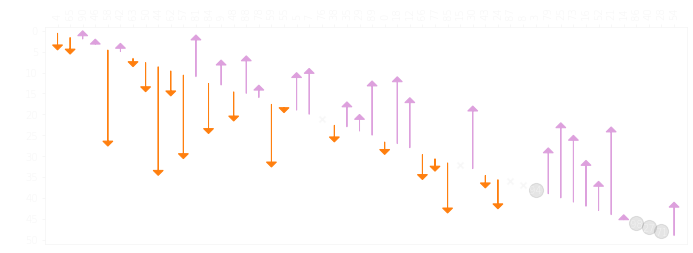

In [11]:
future_run = 'f2100'
n_pheno = 20
w_yield = 1
w_disp = 1
fig_w=11.5
fig_h=4

with plt.rc_context({'axes.edgecolor':'whitesmoke', 
                     'xtick.color':'whitesmoke',
                     'ytick.color':'whitesmoke',
                     'figure.facecolor':'white'}):

    top_phenos_present = rank_top_phenos('present', n_pheno, w_yield, w_disp)
    top_phenos_future = rank_top_phenos(future_run, n_pheno, w_yield, w_disp)

    rank_diffs = []
    new_ranks = []
    for item, pheno in enumerate(top_phenos_present):
        try:
            new_rank = top_phenos_future.index(pheno)
            new_ranks.append(new_rank)
            rank_diffs.append(item-new_rank)
        except (ValueError):
            new_ranks.append(new_rank)
            rank_diffs.append(np.nan)

    # Visualization
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = fig.add_subplot(1, 1, 1)

    phenos = top_phenos_present[:]

    y1s = []
    y2s = []
    for item, pheno in enumerate(phenos):
        y1s.append(n_pheno-item)
        y2s.append((n_pheno-item) + rank_diffs[item])

        if rank_diffs[item] < 0:
            plt.arrow(item, n_pheno-item, 0, rank_diffs[item],
                      head_width=0.8,
                      length_includes_head=True,
                      head_starts_at_zero=True,
                      color='tab:orange')
        elif rank_diffs[item] > 0:
            plt.arrow(item, n_pheno-item, 0, rank_diffs[item],
                      head_width=0.8,
                      length_includes_head=True,
                      color='plum')
        elif rank_diffs[item] == 0:
            plt.scatter(item, n_pheno-item, c='grey', alpha=0.8, marker='_')
        else:
            try:
                new_pheno = top_phenos_future[item]
                if new_pheno in top_phenos_present:
                    plt.scatter(item, n_pheno-item, c='whitesmoke',
                                alpha=0.8, marker='x')
                else:
                    plt.scatter(item, n_pheno-item, c='grey',
                                s=200, alpha=0.2, marker='o')
                    plt.text(item-0.5, n_pheno-item-1,
                             new_pheno, size=10, color='whitesmoke', fontweight='light')
            except IndexError:
                print('future top ranks less than present day')

    # x-axis
    ax.set_xlim(-1, len(top_phenos_present))
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(top_phenos_present)))
    ax.set_xticklabels(top_phenos_present, fontweight='light',
                       fontsize=10, rotation=90)

    # y-axis
    min_y = min(min(y1s), min(y2s))
    min_y_rounded = round(min_y/5)*5
    plt.ylabel('ranking', color='white', fontweight='light', size=14)
    ax.set_ylim(min_y_rounded-1, n_pheno+1)
    ax.set_yticks(np.arange(min_y_rounded, n_pheno+1, 5))
    ax.set_yticklabels(np.arange(0, abs(min_y_rounded)+n_pheno+1, 5)[::-1],
                       fontweight='light')

plt.savefig('/home/disk/eos8/ach315/upscale/figs/rankchange_f2100_top20_y1_d1_transp.png',
            transparent=True, format='png', dpi=800)

future top ranks less than present day
future top ranks less than present day


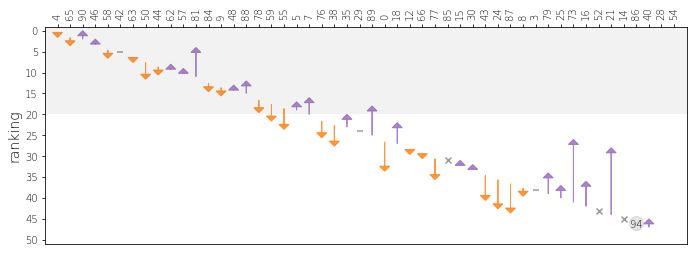

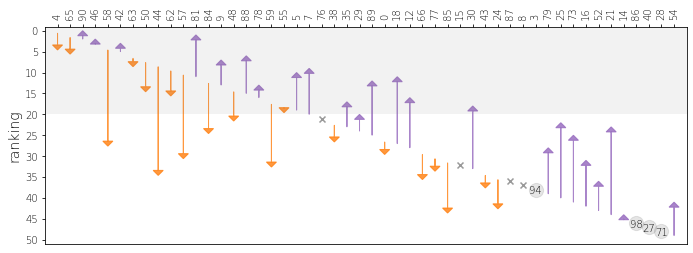

In [3]:
plot_rankchange(20, 1, 1, 'f2050', save=True)
plot_rankchange(20, 1, 1, 'f2100', save=True)

In [41]:
n_pheno = 20
w_yield = 1
w_disp = 1
future_run = 'f2100'

top_phenos_present = rank_top_phenos('present', n_pheno, w_yield, w_disp)
top_phenos_future = rank_top_phenos(future_run, n_pheno, w_yield, w_disp)

rank_diffs = []
new_ranks = []
for item, pheno in enumerate(top_phenos_present):
    try:
        new_rank = top_phenos_future.index(pheno)
        new_ranks.append(new_rank)
        rank_diffs.append(item-new_rank)
    except (ValueError):
        new_ranks.append(new_rank)
        rank_diffs.append(np.nan)

df_rankchange = pd.DataFrame({'phenos': top_phenos_present,
                              'rank_change': rank_diffs})
phenos_improved = list(df_rankchange.nlargest(15,'rank_change')['phenos'])
phenos_improved.extend([94])
phenos_declined = list(df_rankchange.nsmallest(10, 'rank_change')['phenos'])
phenos_declined.extend([76,15,87,8])

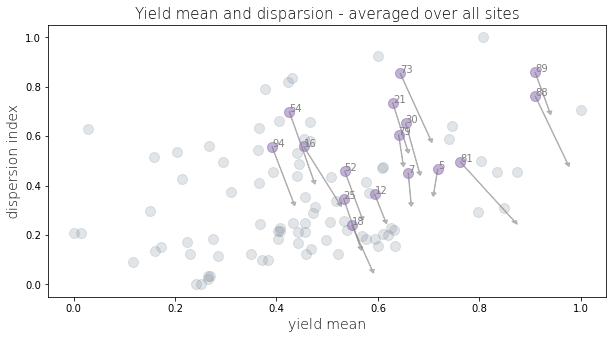

In [60]:
plot_mean_disp_change('present', 'f2100', phenos_improved,
                      'tab:purple', save=True,
                      fig_text='phenos_improved')

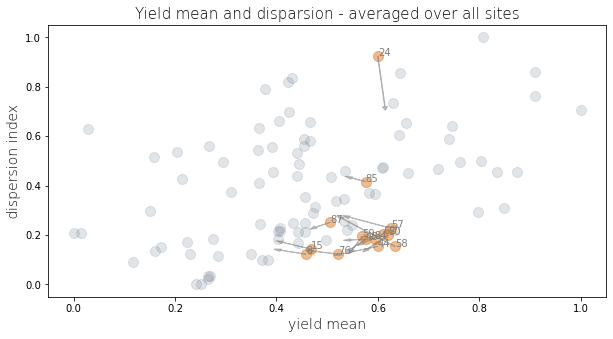

In [61]:
plot_mean_disp_change('present', 'f2100', phenos_declined,
                      'tab:orange', save=True,
                      fig_text='phenos_declined')

## Identify phenotypes that improved most in ranking

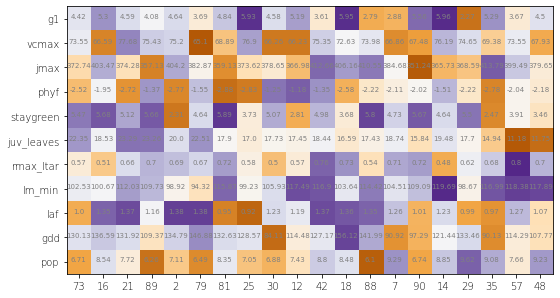

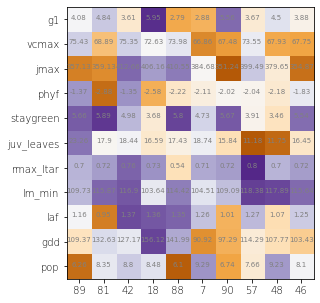

In [24]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2050', 20)
plot_params_heatmap(df_params, phenos_improved)
                    #save=True, save_text='f2050_improved_y1_d1')
plot_params_heatmap(df_params, phenos_targeted, fig_w=6.5, fig_h=5, 
                    save=True, save_text='f2050_targeted_y1_d1')

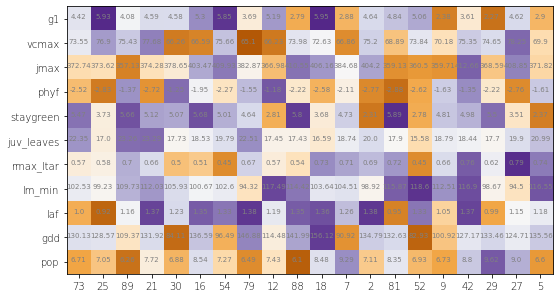

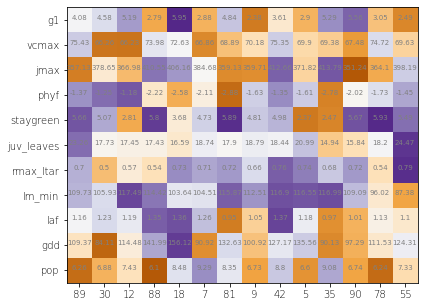

In [18]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
plot_params_heatmap(df_params, phenos_improved, save=True, save_text='f2100_improved_y1_d1')
plot_params_heatmap(df_params, phenos_targeted, fig_w=6.5, save=True, save_text='f2100_targeted_y1_d1')

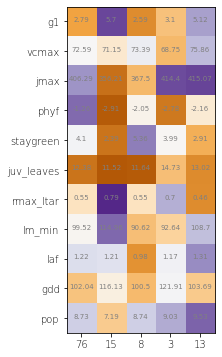

In [17]:
phenos_dropout = [76,15,8,3,13]
plot_params_heatmap(df_params, phenos_dropout)

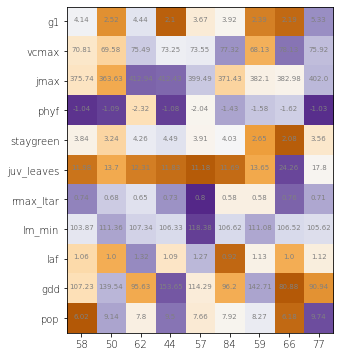

In [4]:
phenos_declined = [58,50,62,44,57,84,59,66,77]
plot_params_heatmap(df_params, phenos_declined)

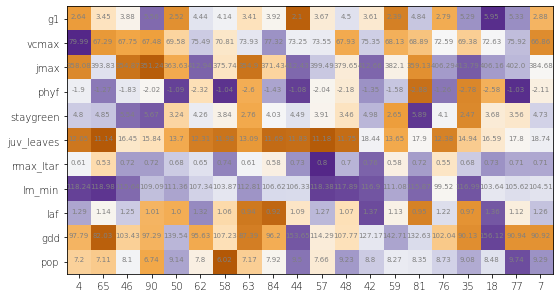

In [58]:
targeted_phenos = [4,65,46,90,50,62,58,63,84,44,57,48,
                   42,59,81,76,35,18,77,7,3,8,15,40,
                   28,31,27,97,17,41,68,96,39]
plot_params_heatmap(df_params, targeted_phenos)

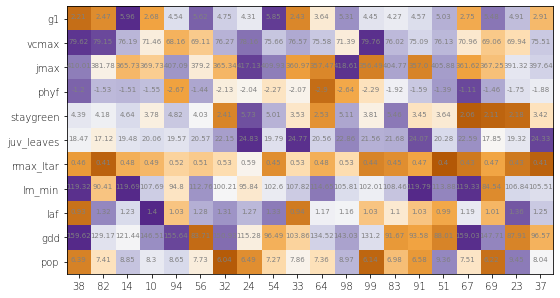

In [59]:
targeted_phenos = [38,82,14,10,94,56,32,24,54,33,64,
                   98,99,83,91,51,67,69,23,37,92,1,93]
plot_params_heatmap(df_params, targeted_phenos)

### Plot out change in yield vs. dispersion

In [4]:
# Identify phenos
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

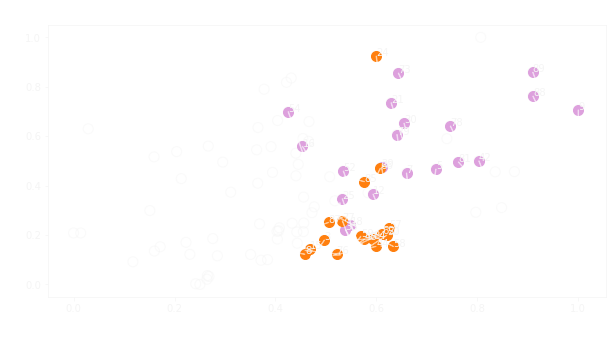

In [18]:
with plt.rc_context({'axes.edgecolor':'whitesmoke', 
                     'xtick.color':'whitesmoke',
                     'ytick.color':'whitesmoke',
                     'figure.facecolor':'white'}):

    run_name_present = 'present'
    run_name_future = 'f2100'
    phenos_improved = phenos_improved[:20]
    phenos_declined = [58,50,62,44,57,84,48,59,66,77,85,87,24,76,15,8,3]
    phenos = phenos_improved + phenos_declined

    yield_mean_norm_present, yield_disp_norm_present = fetch_norm_mean_disp(
        run_name_present)
    yield_mean_norm_future, yield_disp_norm_future = fetch_norm_mean_disp(
        run_name_future)
    diffs_yield, diffs_disp = fetch_mean_disp_diff(
        run_name_present, run_name_future, phenos)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    ax.scatter(yield_mean_norm_present, yield_disp_norm_present,
               marker='o', facecolor='none', edgecolor='whitesmoke',
               s=100, alpha=0.5)
    ax.scatter(yield_mean_norm_present[phenos_improved],
               yield_disp_norm_present[phenos_improved],
               c='plum', s=100)
    ax.scatter(yield_mean_norm_present[phenos_declined],
               yield_disp_norm_present[phenos_declined],
               c='tab:orange', s=100)

    for item, pheno in enumerate(phenos):
        plt.arrow(yield_mean_norm_present[pheno],
                  yield_disp_norm_present[pheno],
                  diffs_yield[item], diffs_disp[item],
                  color='white', alpha=0.5,
                  head_width=0.01)

    for pheno in phenos:
        ax.annotate(pheno, (yield_mean_norm_present[pheno],
                            yield_disp_norm_present[pheno]), c='whitesmoke')

    ax.set_xlabel('yield mean', color='white', fontweight='light', size=14)
    ax.set_ylabel('dispersion index', color='white', fontweight='light', size=14)
    ax.set_title('Yield mean and disparsion - averaged over all sites',
                 color='white', fontweight='light', size=15)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_rankchange_transp.png', 
            transparent=True, format='png', dpi=800)

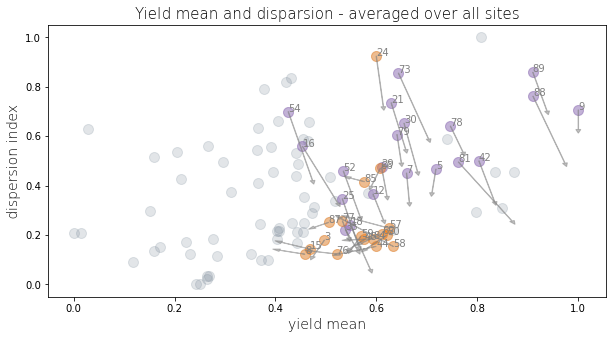

In [5]:
run_name_present = 'present'
run_name_future = 'f2100'
phenos_improved = phenos_improved[:20]
#phenos_declined = [58,50,62,44,57,84,59,66,77]
phenos_declined = [58,50,62,44,57,84,48,59,66,77,85,87,24,76,15,8,3]
phenos = phenos_improved + phenos_declined

yield_mean_norm_present, yield_disp_norm_present = fetch_norm_mean_disp(
    run_name_present)
yield_mean_norm_future, yield_disp_norm_future = fetch_norm_mean_disp(
    run_name_future)
diffs_yield, diffs_disp = fetch_mean_disp_diff(
    run_name_present, run_name_future, phenos)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.scatter(yield_mean_norm_present, yield_disp_norm_present,
           c='slategrey', s=100, alpha=0.2)
ax.scatter(yield_mean_norm_present[phenos_improved],
           yield_disp_norm_present[phenos_improved],
           c='tab:purple', s=100, alpha=0.4)
ax.scatter(yield_mean_norm_present[phenos_declined],
           yield_disp_norm_present[phenos_declined],
           c='tab:orange', s=100, alpha=0.4)

for item, pheno in enumerate(phenos):
    plt.arrow(yield_mean_norm_present[pheno],
              yield_disp_norm_present[pheno],
              diffs_yield[item], diffs_disp[item],
              color='grey', alpha=0.5,
              head_width=0.01)

for pheno in phenos:
    ax.annotate(pheno, (yield_mean_norm_present[pheno],
                        yield_disp_norm_present[pheno]), c='grey')

#ax.set_ylim(-0.1, 1.1)
#ax.set_xlim(-0.1, 1.1)
ax.set_xlabel('yield mean', fontweight='light', size=14)
ax.set_ylabel('dispersion index', fontweight='light', size=14)
ax.set_title('Yield mean and disparsion - averaged over all sites',
             fontweight='light', size=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_rankchange.png', format='png', dpi=800)

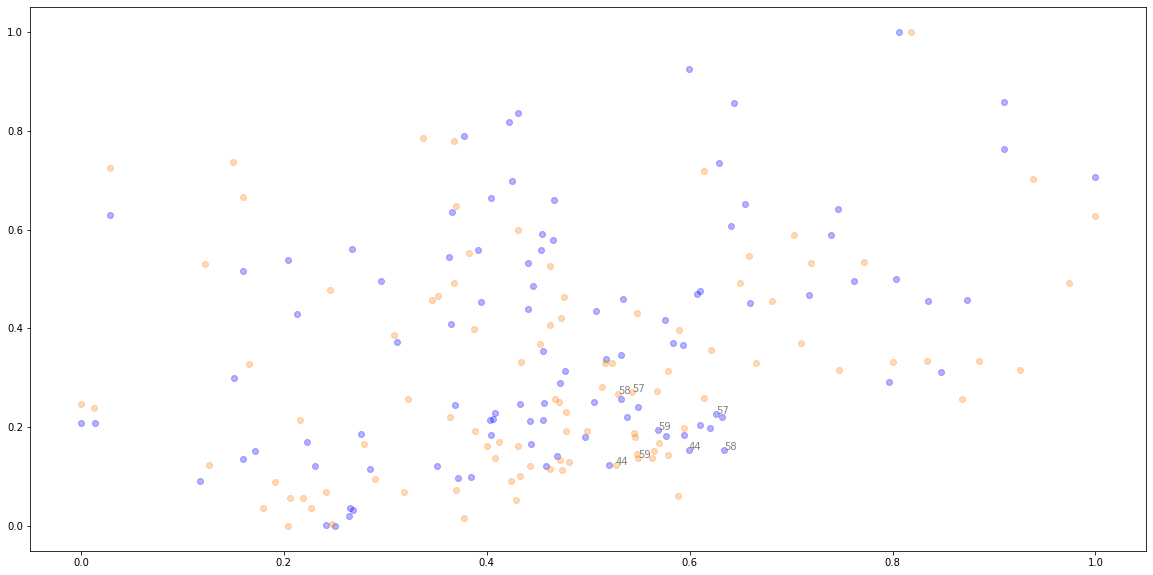

In [39]:
yield_mean_norm_present, yield_disp_norm_present = fetch_norm_mean_disp(
    run_name_present)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.scatter(yield_mean_norm_present, yield_disp_norm_present, alpha=0.3, color='blue')
for pheno in [44,58,57,59]:
    ax.annotate(pheno, (yield_mean_norm_present[pheno],
                        yield_disp_norm_present[pheno]), c='grey')

yield_mean_norm_future, yield_disp_norm_future = fetch_norm_mean_disp('f2100')
ax.scatter(yield_mean_norm_future, yield_disp_norm_future, alpha=0.3, color='tab:orange')
for pheno in [44,58,57,59]:
    ax.annotate(pheno, (yield_mean_norm_future[pheno],
                        yield_disp_norm_future[pheno]), c='grey')


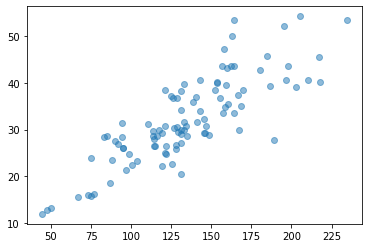

In [106]:
plt.scatter(means, means-means_f2100, alpha=0.5)

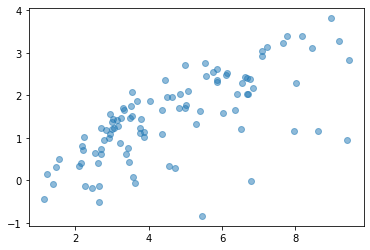

In [104]:
plt.scatter(disps, disps-disps_f2100, alpha=0.5)

Text(0.5, 1.0, 'Yield mean and disparsion - averaged over all sites')

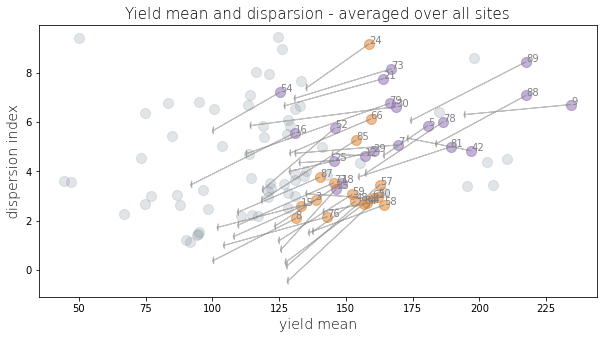

In [40]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

df = df_all
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)
df_mean = pd.DataFrame(mx_mean)
df_disp = pd.DataFrame(mx_disp)
means = df_mean.mean(axis=1)
disps = df_disp.mean(axis=1)


df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_f2100.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

df = df_all
groups = ['cvar', 'site']
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, 'mean', sim)
mx_variance = agg_sims(df, groups, 'variance', sim)
mx_disp = np.divide(mx_variance, mx_mean)
df_mean = pd.DataFrame(mx_mean)
df_disp = pd.DataFrame(mx_disp)
means_f2100 = df_mean.mean(axis=1)
disps_f2100 = df_disp.mean(axis=1)


diffs_yield = means_f2100 - means
diffs_disp = disps_f2100 - disps


run_name_present = 'present'
run_name_future = 'f2100'
phenos_improved = phenos_improved[:20]
phenos_declined = [58,50,62,44,57,84,48,59,66,77,85,87,24,76,15,8,3]
phenos = phenos_improved + phenos_declined



fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.scatter(means, disps,
           c='slategrey', s=100, alpha=0.2)
ax.scatter(means[phenos_improved],
           disps[phenos_improved],
           c='tab:purple', s=100, alpha=0.4)
ax.scatter(means[phenos_declined],
           disps[phenos_declined],
           c='tab:orange', s=100, alpha=0.4)

for item, pheno in enumerate(phenos):
    plt.arrow(means[pheno],
              disps[pheno],
              diffs_yield[item], diffs_disp[item],
              color='grey', alpha=0.5,
              head_width=0.3)

for pheno in phenos:
    ax.annotate(pheno, (means[pheno], disps[pheno]), c='grey')

#ax.set_ylim(-0.1, 1.1)
#ax.set_xlim(-0.1, 1.1)
ax.set_xlabel('yield mean', fontweight='light', size=14)
ax.set_ylabel('dispersion index', fontweight='light', size=14)
ax.set_title('Yield mean and disparsion - averaged over all sites',
             fontweight='light', size=15)


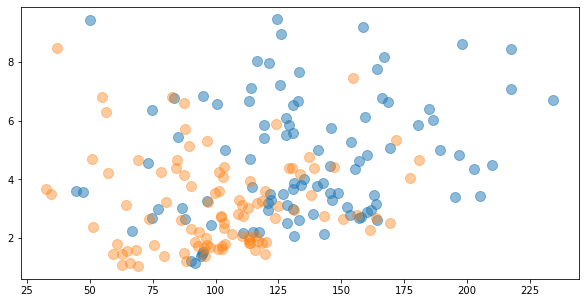

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.scatter(means, disps, s=100, alpha=0.5)
ax.scatter(means_f2100, disps_f2100, s=100, alpha=0.4)


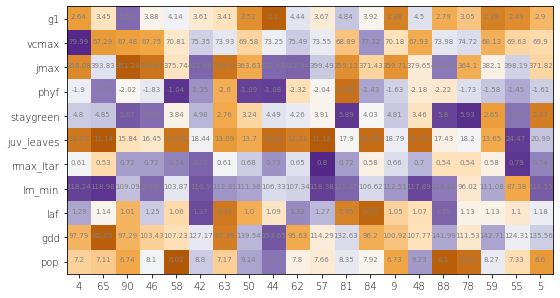

In [44]:
top_phenos = rank_top_phenos('present',20,1,1)
plot_params_heatmap(df_params, top_phenos)

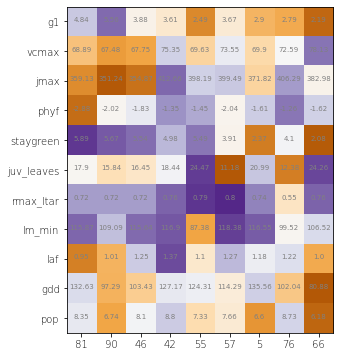

In [42]:
plot_params_heatmap(df_params, [81,90,46,42,55,57,5,76,66])

## Shift in top performers param makeup

In [22]:
top_phenos = rank_top_phenos('present', 20, 1, 1)
top_phenos = top_phenos[:15]

In [23]:
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

for param in params:
    df_params_fold[param] = fold(df_params[param],
                                 param_range[param][0],
                                 param_range[param][1])

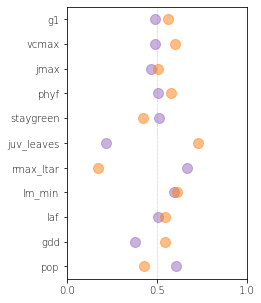

In [14]:
phenos_early = [4,65,46,90,50,62,58,63,84,44,57,
                48,42,59,81,76,35,18,77,7,3,8,15,
                40,28,31,27,97,17,41,68,96,39]
phenos_late = [38,82,14,10,94,56,32,24,54,33,64,
               98,99,83,91,51,67,69,23,37,92,1,93]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

for item, param in enumerate(params[::-1]):
    ax.scatter(df_params_fold.iloc[phenos_early][param].mean(), item,
               color='tab:purple', s=100, alpha=0.5)
    ax.scatter(df_params_fold.iloc[phenos_late][param].mean(), item,
               color='tab:orange', s=100, alpha=0.5)
    
plt.xlim(0,1)
plt.xticks(fontweight='light')
ax.set_xticks([0,0.5,1])
ax.set_yticks(np.arange(11))
ax.set_yticklabels(params[::-1], fontweight='light')
ax.axvline(x=0.5, color='grey', linewidth=0.5, linestyle=':')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_gfstart.png', format='png', dpi=800)

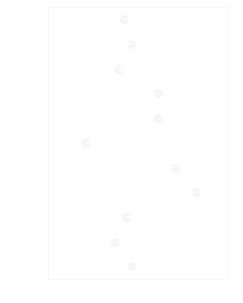

In [36]:
with plt.rc_context({'axes.edgecolor':'whitesmoke', 
                     'xtick.color':'white',
                     'ytick.color':'white',
                     'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)

    for item, param in enumerate(params[::-1]):
        p1 = df_params_fold.iloc[top_phenos][param].mean()    
        p2 = df_params_fold.iloc[phenos_targeted][param].mean()
        ax.scatter(df_params_fold.iloc[top_phenos][param].mean(), item,
                   color='whitesmoke', s=60)
        ax.arrow(p1, item, (p2-p1), 0, color='white', alpha=0.8,
                 head_length=0.03, head_width=0.25)

    ax.set_xlim(0,1)
    ax.set_ylim(-0.5,10.5)
    plt.xticks(fontweight='light')
    ax.set_xticks([0,0.5,1])
    ax.set_yticks(np.arange(11))
#    ax.set_yticklabels(params[::-1], color='white', fontweight='light')
    ax.set_yticklabels(['g1','Vcmax','Jmax','phyf','sg','leaf',
                        'ltar','len','laf', 'pdate', 'pop'][::-1],
                       color='white', fontweight='light')

    ax.axvline(x=0.5, color='whitesmoke', linewidth=0.5, linestyle=':')
    fig.subplots_adjust(left=0.3, right=0.8)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_change_transp.png',
            transparent=True, format='png', dpi=800)

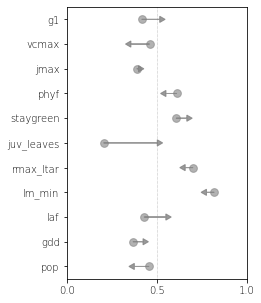

In [26]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

for item, param in enumerate(params[::-1]):
    p1 = df_params_fold.iloc[top_phenos][param].mean()    
    p2 = df_params_fold.iloc[phenos_targeted][param].mean()
    ax.scatter(df_params_fold.iloc[top_phenos][param].mean(), item,
               color='grey', s=60, alpha=0.6)
    ax.arrow(p1, item, (p2-p1), 0, color='grey', alpha=0.8,
             head_length=0.03, head_width=0.25)
    
ax.set_xlim(0,1)
ax.set_ylim(-0.5,10.5)
plt.xticks(fontweight='light')
ax.set_xticks([0,0.5,1])
ax.set_yticks(np.arange(11))
ax.set_yticklabels(['g1', 'Vcmax', 'Jmax', 'phyf', 
                    'sg', 'leaf', 'ltar', 'len',
                    'laf', 'pdate', 'pop'],
                   fontweight='light')
ax.axvline(x=0.5, color='grey', linewidth=0.5, linestyle=':')
fig.subplots_adjust(left=0.3, right=0.8)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_change_present.png', format='png', dpi=800)
plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_change.png', format='png', dpi=800)

## Shift in performance distribution

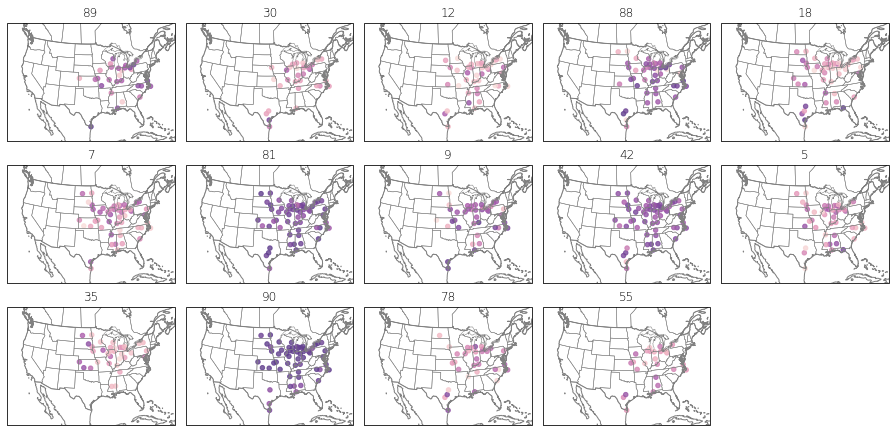

In [111]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_f2100.yml')

phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

# Identify top phenos
df_pheno, mx = identify_top_phenos('f2100', 20, 1, 1)

# Determine all of the high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
# - performance determined by the counts a specific phenotype makes it
# - as the top n performers
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(phenos_targeted):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = mx[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)

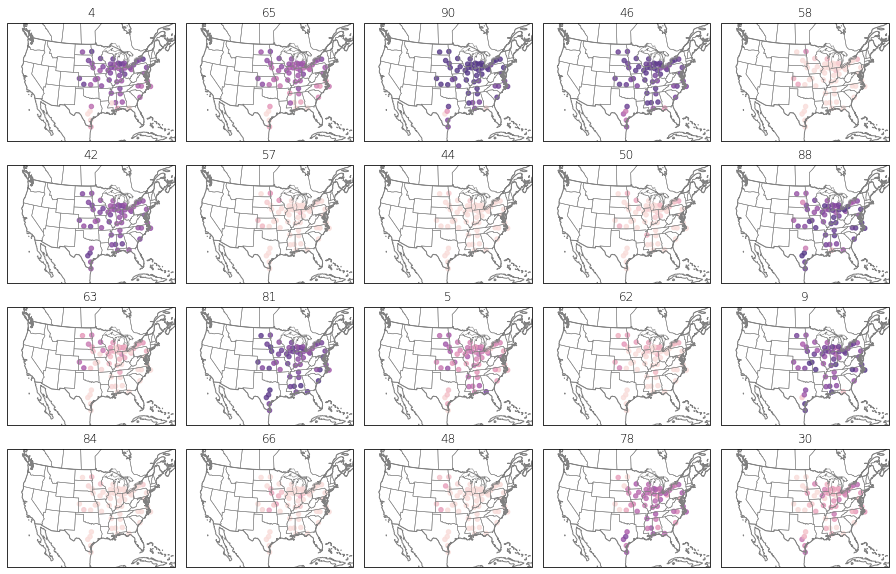

In [21]:
from palettable.cartocolors.sequential import PurpOr_6


df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_f2100.yml')
df_extended, df_stuck = parse_mature(df_all)

# Parameters for identify_top_phenos
n_pheno = 5
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine all of the high-performing phenotypes
# - not ranking any of them yet, just figuring out all the phenotypes
# - that had at least made it into top 5 at at least one location
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
# - performance determined by the counts a specific phenotype makes it
# - as the top n performers
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)
    
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_top_pheno_ranking.png', format='png', dpi=800)

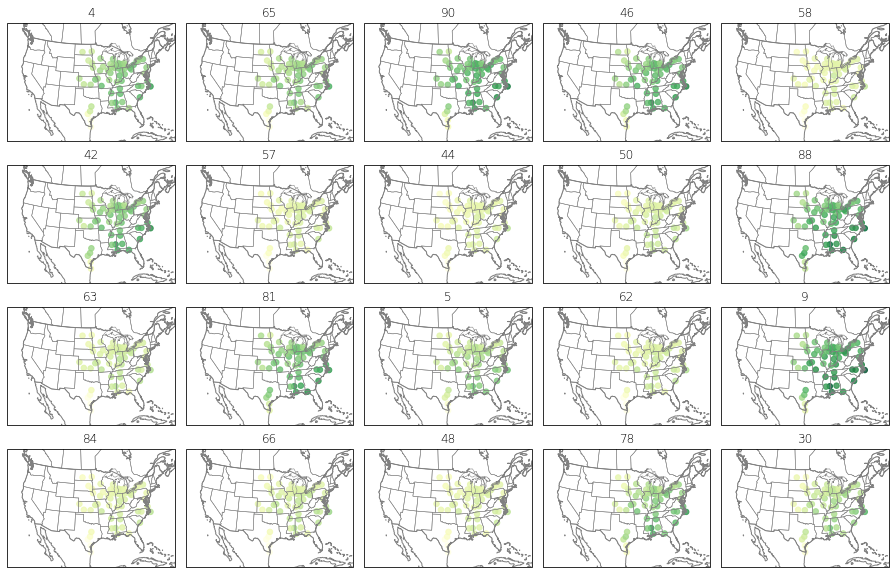

In [22]:
from palettable.colorbrewer.sequential import YlGn_9

extent = [-123, -72, 19, 53]
df_sub = df_all.groupby(['cvar', 'site']).mean().reset_index()

fig = plt.figure(figsize=(16,10))

for count, cvar in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,count+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    df = df_sub[df_sub.cvar == cvar]
    ax.scatter(df.lon, df.lat, 
               transform=ccrs.PlateCarree(), 
               s=30, c=df.dm_ear, 
               cmap=YlGn_9.mpl_colormap,
               vmin=80, vmax=250, alpha=0.8)
    ax.set_extent(extent)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(cvar, fontweight='light')

fig.subplots_adjust(wspace=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_yield_top_phenos_sortby_top_prevalence.png', format='png', dpi=800)

### Performance change in climate space

In [3]:
# Current climate
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    os.path.join(DATA_PATH, 'files', f'filepaths_{run_name}.yml'))
df_grouped_present = df_all.groupby(['cvar', 'site']).mean().reset_index()
df_gseason_climate = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))
df_waterdeficit = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_temp_gf_present, df_vpd_gf_present, df_wd_gf_present = phenostage_climate(
    df_all, df_gseason_climate, df_waterdeficit, 3)

# f2100 climate
run_name = 'f2100'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    os.path.join(DATA_PATH, 'files', f'filepaths_{run_name}.yml'))
df_grouped_f2100 = df_all.groupby(['cvar', 'site']).mean().reset_index()
df_gseason_climate = pd.read_csv(
    os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))
df_temp_gf_f2100, df_vpd_gf_f2100, df_wd_gf_f2100 = phenostage_climate(
    df_all, df_gseason_climate, df_waterdeficit, 3)

# additional phenostages
#df_temp_em, df_vpd_em, df_wd_em = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 0)
#df_temp_ti, df_vpd_ti, df_wd_ti = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 1)
#df_temp_ts, df_vpd_ts, df_wd_ts = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 2)
#df_temp_em_f2100, df_vpd_em_f2100, df_wd_em_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 0)
#df_temp_ti_f2100, df_vpd_ti_f2100, df_wd_ti_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 1)
#df_temp_ts_f2100, df_vpd_ts_f2100, df_wd_ts_f2100 = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 2)
    
# Overall gseason climate
#site_temps = df_all.groupby('site').mean().temp
#site_vpds = df_all.groupby('site').mean().vpd
#site_precips = df_all.groupby('site').mean().precip

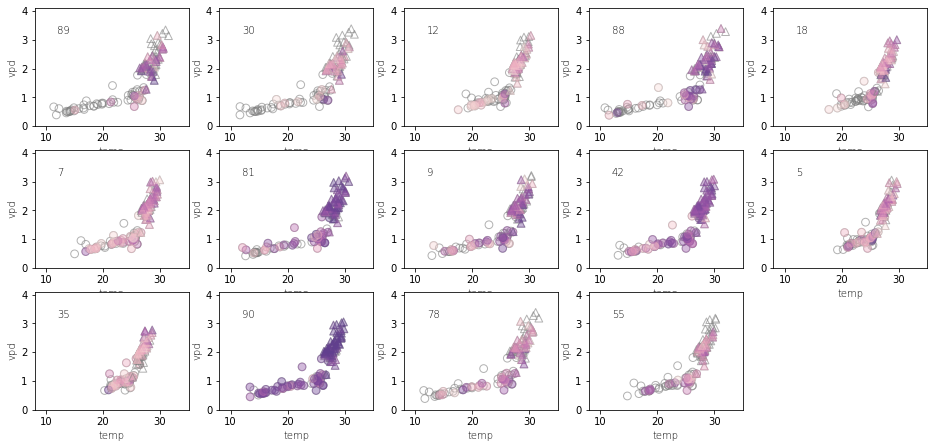

In [4]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_future = identify_top_phenos('f2100', 20, 1, 1)

plot_cspace_rank(phenos_targeted, mx_present, mx_future,
                 df_temp_gf_present, df_vpd_gf_present,
                 df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

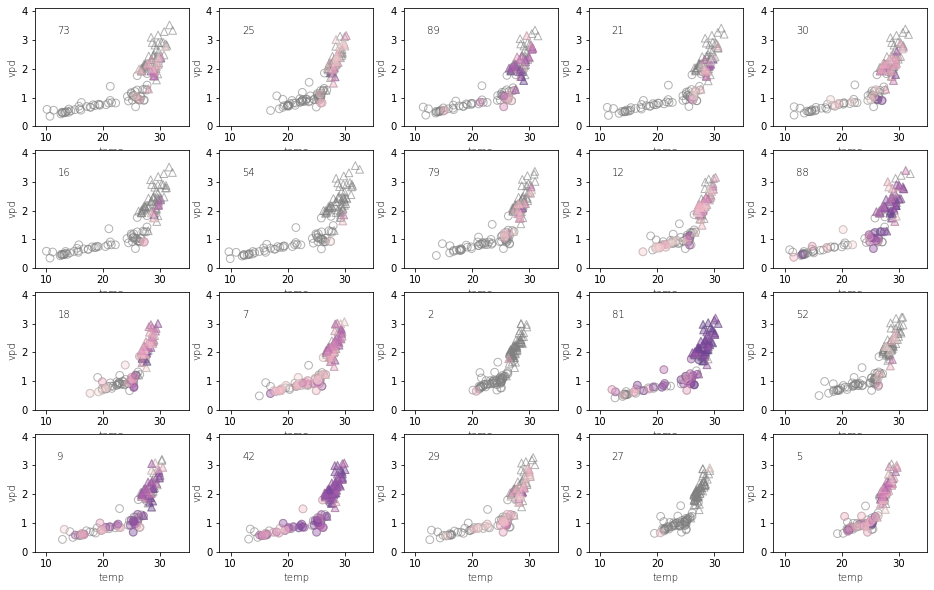

In [5]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_future = identify_top_phenos('f2100', 20, 1, 1)

plot_cspace_rank(phenos_improved[:20], mx_present, mx_future,
                 df_temp_gf_present, df_vpd_gf_present,
                 df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

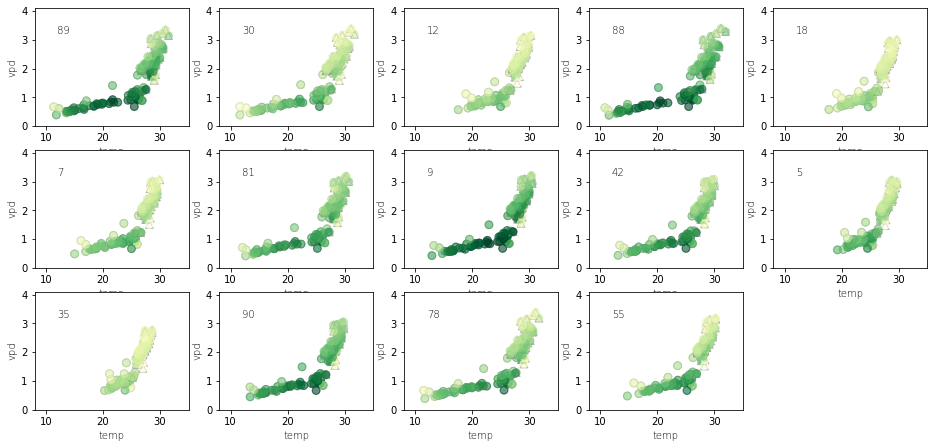

In [4]:
# Identify targeted phenos & ranks
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

plot_cspace_yield(phenos_targeted, df_grouped_present, df_grouped_f2100,
                  df_temp_gf_present, df_vpd_gf_present,
                  df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

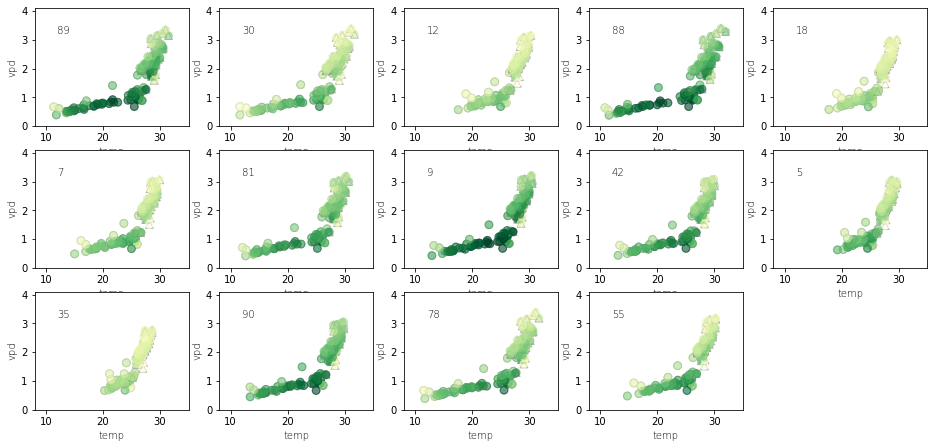

In [3]:
# Identify targeted phenos & ranks
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

plot_cspace_yield(phenos_targeted, df_grouped_present, df_grouped_f2100,
                  df_temp_gf_present, df_vpd_gf_present,
                  df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')

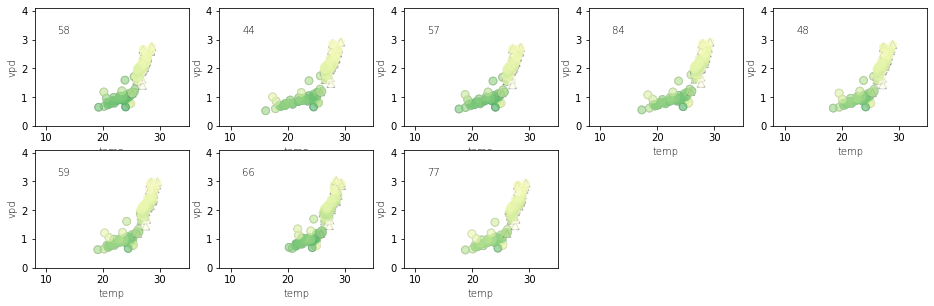

In [10]:
phenos_targeted = [58,44,57,84,48,59,66,77]
plot_cspace_yield(phenos_targeted, df_grouped_present, df_grouped_f2100,
                  df_temp_gf_present, df_vpd_gf_present,
                  df_temp_gf_f2100, df_vpd_gf_f2100, 'temp', 'vpd')